# Исследование гипотез и анализ результатов A/B теста для интернет-магазина

**Описание проекта**

В рамках проекта проводится маркетинговое исследование для крупного интернет-магазина.

Основа исследования - список гипотез с мероприятиями по увеличению выручки интернет-магазина, а также информация о заказах и посещениях пользователей по результатам проведения A/B тестирования.

**Цели проекта**: 
1. Провести приоритизацию гипотез, направленных на увеличение выручки интернет-магазина;
2. Провести анализ результатов А/В-теста;
3. Сформировать и аргументировать решение об остановке или продолжении тестирования.

**Описание исходных данных**

*Гипотезы — ‘[hypothesis.csv](https://code.s3.yandex.net/datasets/hypothesis.csv)':*

'Hypothesis' — краткое описание гипотезы;\
'Reach' — охват пользователей по 10-балльной шкале;\
'Impact' — влияние на пользователей по 10-балльной шкале;\
'Confidence' — уверенность в гипотезе по 10-балльной шкале;\
'Efforts' — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

*Заказы — ‘[orders.csv](https://code.s3.yandex.net/datasets/orders.csv)’:*

'transactionId' — идентификатор заказа;\
'visitorId' — идентификатор пользователя, совершившего заказ;\
'date' — дата, когда был совершён заказ;\
'revenue' — выручка заказа;\
'group' — группа A/B-теста, в которую попал заказ.

*Посещения — ‘[visitors.csv](https://code.s3.yandex.net/datasets/visitors.csv)’:*

'date' — дата;\
'group' — группа A/B-теста;\
'visitors' — количество пользователей в указанную дату в указанной группе A/B-теста.

**Цели исследования**

1. Изучить следующие параметры оценки гипотез и A/B тестирования: 
    * *гипотезы*: описание гипотезы, охват пользователей, влияние на пользователей, уверенность в оценке, трудозатраты на реализацию;
    * *заказы*: дата и стоимость заказа, группа A/B-теста, в которую попал заказ;
    * *посещения*: дата и количество посещений пользователей, группа A/B-теста.
2. Произвести предобработку данных: корректировка типов данных, поиск пропусков, дубликатов, выбивающихся значений и проверка пересечений пользователей в группах A/B-теста.
3. Осуществить расчет оценки приоритета гипотез методами ICE и RICE, определить наиболее перспективные с учетом различных факторов.
4. Сформировать агрегированный датафрейм с кумулятивными данными по заказам и пользователям в разрезе групп тестирования.
5. Изучить и визуализировать динамику изменения кумулятивных метрик по группам тестирования:
    - кумулятивная выручка;
    - кумулятивный средний чек;
    - относительное изменение кумулятивного среднего чека группы B к группе A;
    - кумулятивное среднее количество заказов на посетителя;
    - относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A;
6. Проследить распределение количества заказов по пользователям, а также распределение стоимостей заказов.
7. Рассчитать 95-й и 99-й перцентили количества заказов на пользователя и стоимости заказов в целях отсечения аномальных значений.
8. Определить наиболее подходящий статистический тест для проверки гипотез с учетом специфики распределения данных.
9. Выдвинуть нулевую и альтернативную гипотезы для проведения статистических тестов на основе "сырых" и "очищенных" данных для оценки статистической значимости следующих параметров:
    - различия в среднем количестве заказов на посетителя между группами A/B-теста;
    - различия в среднем чеке заказа между группами A/B-теста.
10. Проанализировать результаты статистического теста.
11. Сформировать и аргументировать решение о продолжении/остановке A/B-теста.
10. Подготовить итоговые выводы исследования.

## Загрузка и первичный анализ данных

In [1]:
# импортируем библиотеки

import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# создаем датафреймы с данными
try:
    hypothesis, orders, visitors = ( #гипотезы, заказы, посещения
        pd.read_csv('/datasets/hypothesis.csv', sep = ','),
        pd.read_csv('/datasets/orders.csv', sep = ',', parse_dates=['date']),
        pd.read_csv('/datasets/visitors.csv', sep = ',', parse_dates=['date']))
except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv', sep = ','),
        pd.read_csv('orders.csv', sep = ',', parse_dates=['date']),
        pd.read_csv('visitors.csv', sep = ',', parse_dates=['date']))

In [3]:
# убираем ограничения по ширине столбцов
pd.set_option('display.max_colwidth', None)

# убираем ограничения на количество столбцов
pd.set_option('display.max_columns', None)

In [4]:
# задаем функцию для получения базовой информации о датафреймах
def basic_data_info(df):
    display(df, df.info())
    print('-' * 50)
    print('Количество пропусков:')
    display(df.isna().sum())
    print('-' * 50)
    print('Количество явных дубликатов:')
    display(df.duplicated().sum())
    print('-' * 50)
    print('Проверка корректности наименований столбцов:')
    display(df.columns)

In [5]:
# получаем информацию о датафрейме 'visitors'
basic_data_info(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


None

--------------------------------------------------
Количество пропусков:


date        0
group       0
visitors    0
dtype: int64

--------------------------------------------------
Количество явных дубликатов:


0

--------------------------------------------------
Проверка корректности наименований столбцов:


Index(['date', 'group', 'visitors'], dtype='object')

In [6]:
# получаем информацию о датафрейме 'orders'
basic_data_info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


None

--------------------------------------------------
Количество пропусков:


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

--------------------------------------------------
Количество явных дубликатов:


0

--------------------------------------------------
Проверка корректности наименований столбцов:


Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [7]:
# получаем информацию о датафрейме 'hypothesis'
basic_data_info(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


None

--------------------------------------------------
Количество пропусков:


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

--------------------------------------------------
Количество явных дубликатов:


0

--------------------------------------------------
Проверка корректности наименований столбцов:


Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')

**Первичные итоги ознакомления с данными:**

1. Датафрейм "Посещения" содержит 62 строки с информацией о посещениях сайта, собранных на основе 3 характеристик (дата посещения, группа A/B теста и количество пользователей в указанную дату в разрезе данной группы A/B-теста).
2. Датафрейм "Заказы" содержит информацию по 1197 заказам пользователей с учетом 3 характеристик (идентификатор заказа, идентификатор пользователя, совершившего заказ, дата заказа, объем выручки с заказа и группа A/B-теста, в которую попал заказ).
3. Датафрейм "Гипотезы" содержит информацию по 9 гипотезам, которые можно оценить на основе 4 параметров: 'reach', impact', 'confidence', 'efforts'.
4. Во всех датафреймах отсутствуют пропуски. Явные дубликаты не выявлены.
5. Наименования столбцов имеют корректный вид и пригодны для дальнейшей работы. Однако есть смысл переименовать столбцы в соответствии со стилем snake_case (приведение к строчному регистру).

## Предобработка данных

Скорректируем наименования столбцов в соответствии с предложенными рекомендациями.

In [8]:
# корректировка названий столбцов в датафреймах 'hypothesis' и 'orders'
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

# проверка результатов
display(hypothesis.columns, orders.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [9]:
# проверим группы A/B теста на совпадения пользователей

a_group = orders.query('group == "A"')['visitor_id']
b_group = orders.query('group == "B"')['visitor_id']
ab_match = b_group[b_group.isin(a_group)]
print('Количество совпадающих пользователей в двух группах A/B теста:', ab_match.nunique())
print('Доля совпадающих пользователей в двух группах A/B теста: {0:.2f}%'.format((ab_match.nunique()/orders['visitor_id'].nunique()) * 100))

Количество совпадающих пользователей в двух группах A/B теста: 58
Доля совпадающих пользователей в двух группах A/B теста: 5.63%


В целях соблюдения одного из главных принципов A/B теста, где один уникальный пользователь видит только одну версию сайта на протяжении всего периода тестирования, удалим из анализа информацию об активности пользователей, оказавшихся сразу в двух группах.

In [10]:
# исключаем наблюдения о совпадающих пользователях в двух группах A/B теста
orders = orders.query('visitor_id not in @ab_match')
print('Количество уникальных пользователей после корректировки:', orders['visitor_id'].nunique())

Количество уникальных пользователей после корректировки: 973


Посмотрим соотношение количества пользователей по группам тестирования.

In [11]:
ab_distribution = (
        orders.groupby('group')
        .agg({'transaction_id': 'count', 'visitor_id': 'nunique'})
        .rename(columns={'transaction_id': 'total_orders', 'visitor_id':'unique_users'})
)
ab_distribution['share, %'] = round((ab_distribution['total_orders'] / ab_distribution['total_orders'].sum() *100), 2)
display(ab_distribution)

,total_orders,unique_users,"share, %"
group,,,
A,468,445,46.06
B,548,528,53.94


Разница в количестве наблюдений между группами составляет порядка 8% с перевесом группы В. При этом не представляется возможным привести выборки к равному количеству пользователей, не нарушив результаты тестирования. Поэтому оставим выявленную погрешность без изменений.

In [12]:
# определим минимальную и максимальную даты тестирования

print('Минимальная дата тестирования:', orders['date'].min())
print('Максимальная дата тестирования:', orders['date'].max())

Минимальная дата тестирования: 2019-08-01 00:00:00
Максимальная дата тестирования: 2019-08-31 00:00:00


Проверим **результаты** предобработки данных.

In [13]:
# выводим результаты предобработки данных по датафреймам
visitors.info()
print('-'* 50)
print()
orders.info()
print('-'* 50)
print()
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB
-------

**Итоги предобработки данных:**
1. Скорректированы наименования столбцов в соответствии со змеиным стилем.
2. Исключены из анализа сведения о пользователях, попавших сразу в две группы A/B теста. Сформирован обновленный датафрейм с заказами, содержащий 1016 записей об активности 973 уникальных пользователей.
3. Наблюдения для A/B теста представлены за период **с 1 по 31 августа 2019 года**.

## Приоритизация гипотез

В целях отбора и запуска тестирования только наиболее перспективных бизнес-идей, предложенных отделом маркетинга, обратимся к следующим методам `ICE` и `RICE` для приоритизации гипотез.\
Выбор метода ранжирования гипотез зависит от степени влияния фактора *охвата пользователей* на рост финансовых показателей компании.

### Оценка гипотез методом ICE

В концепции метода ICE расчёт оценки приоритета осуществляется по формуле:

**`ICE = Impact x Confidence / Efforts`**

*Impact - влияние на пользователей;\
Confidence - уверенность в оценке;\
Efforts - трудозатраты на реализацию.*

In [14]:
# добавим новый столбец с расчетом оценки ICE
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
display(hypothesis.sort_values(by='ice', ascending=False))

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### Оценка гипотез методом RICE

В концепции метода RICE расчёт оценки приоритета осуществляется по формуле:

**`RICE = Reach x Impact x Confidence / Efforts`**

*Reach - охват пользователей;\
Impact - влияние на пользователей;\
Confidence - уверенность в оценке;\
Efforts - трудозатраты на реализацию.*

In [15]:
# добавим новый столбец с расчетом оценки RICE
hypothesis['rice'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
display(hypothesis.drop(['ice'], axis = 1).sort_values(by='rice', ascending=False))

,hypothesis,reach,impact,confidence,efforts,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,3.0


**Выводы о приоритизации гипотез**


В соответствии с проведенной оценкой приоритетности методами ICE и RICE в топ-3 гипотезы по каждому методу вошли следующие маркетинговые предложения:

1. *Оценка методом ICE:*

- скидка в день рождения (гипотеза № 8);
- охват новых рекламных каналов для привлечения пользователей (гипотеза №0);
- внедрение формы подписки пользователей для рекламных email-рассылок (гипотеза № 7).

Все эти гипотезы характеризуются максимальными значениями параметров *влияния* (impact: 7-10 баллов) и *уверенности* (confidence: 8-9 баллов). В то же время для них фиксируется существенный уровень *трудозатрат* (efforts: 5-6 баллов), который нивелируется высокими баллами по влиянию и уверенности в оценке.

2. *Оценка методом RICE:*

- внедрение формы подписки пользователей для рекламных email-рассылок (гипотеза № 7);
- добавление блока с рекомендациями товаров (гипотеза № 2);
- охват новых рекламных каналов для привлечения пользователей (гипотеза №0).

В случае применения фреймворка RICE порядок и состав топ-3 гипотез меняется с учетом параметра *охвата* (reach).\
Так, гипотеза №8, лидирующая в оценке методом ICE, опустилась на 5 место в связи с минимальной оценкой охвата (1 балл). Это связано с тем, что акция скидки ко дню рождения может быть доступна пользователям только раз в году, что существенно сужает возможности ее применения.\
Гипотезы №7 и №2 характеризуются максимальным охватом (8-10 баллов), поскольку затрагивают большинство пользователей.\
Гипотеза №0 проигрывает по охвату (всего 3 балла), но имеет максимальное влияние (10 баллов) и значительную уверенность в оценке (8 баллов), что делает ее заметной в общем рейтинге.

Таким образом, наиболее приоритетными гипотезами, учитывающими параметр охвата пользователей, являются гипотезы №7, №2 и №0. Именно на них необходимо обратить внимание в случае планирования A/B-теста.

##  Анализ результатов A/B-теста

Для анализа и визуализации результатов A/B теста соберем в агрегированный датафрейм сведения о дате, группе теста, кумулятивные данные о количестве заказов, покупателей, среднем чеке и количестве посетителей за каждый день теста.

In [16]:
# создаем массив уникальных пар значений дата-группа теста
dates_groups = orders[['date', 'group']].drop_duplicates()

# агрегированные кумулятивные по дням данные о заказах
orders_agg = (dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])]
    .agg({
        'date': 'max',
        'group': 'max',
        'transaction_id': 'nunique',
        'visitor_id': 'nunique',
        'revenue': 'sum'}), axis=1,)
    .sort_values(by=['date', 'group']))

# агрегированные кумулятивные по дням данные о пользователях
visitors_agg = (dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                      visitors['group'] == x['group'])]
    .agg({
        'date': 'max', 
        'group': 'max', 
        'visitors': 'sum'}), axis=1)
    .sort_values(by=['date', 'group']))

# объединяем кумулятивные данные о заказах и пользователях
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors']

display(cumulative_data)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


Получили датафрейм, содержащий *62 наблюдения* для обеих групп тестирования - по 31 на каждую группу.

### Анализ кумулятивных метрик

#### График кумулятивной выручки по группам A/B теста

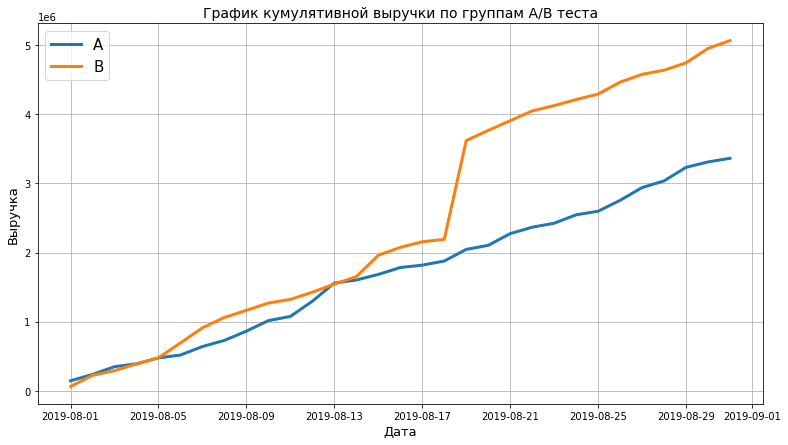

In [17]:
# кумулятивное количество заказов и кумулятивная выручка в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][
    ['date', 'revenue', 'orders']
]

# кумулятивное количество заказов и кумулятивная выручка в группе В
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

#строим графики кумулятивной выручки по дням и группам теста
#группа А
plt.figure(figsize=(13, 7))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A', linewidth=3)

#группа B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B', linewidth=3)

plt.title('График кумулятивной выручки по группам A/B теста', size = 14)
plt.xlabel('Дата', size = 13)
plt.ylabel("Выручка", size = 13)
plt.grid(True)
plt.legend(fontsize=15);

Из графика видим, что в первые 2 недели тестирования кумулятивная выручка росла для обеих групп практически линейно с небольшим перевесом для группы B. Однако **19 августа 2019 г.** наблюдается резкий скачок выручки в группе B - это может говорить о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.
После этого обе группы демонстрируют равномерный рост со стабильным разрывом в 2 млн.ед. выручки в пользу покупателей из группы B.

#### График кумулятивного кумулятивного среднего чека по группам A/B теста

Расчёт среднего чека производится по формуле:

**`Средний чек = выручка / количество заказов`**

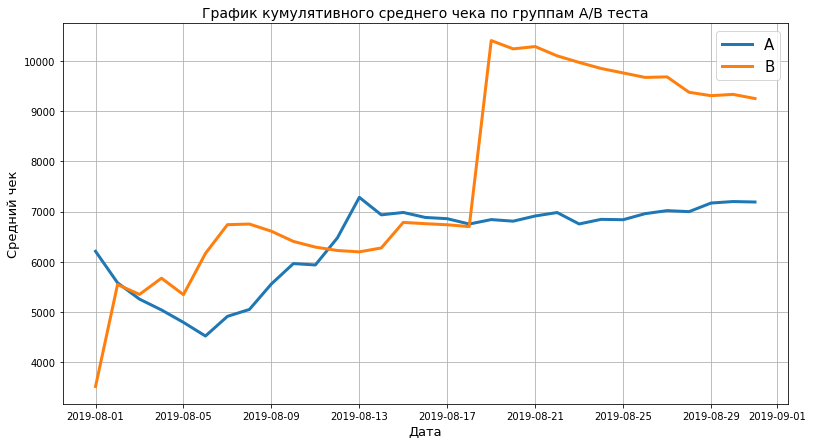

In [18]:
# строим графики кумулятивного среднего чека
# группа А
plt.figure(figsize=(13, 7))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A', linewidth=3)

# группа В
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B', linewidth=3)


plt.title('График кумулятивного среднего чека по группам A/B теста', size = 14)
plt.xlabel('Дата', size = 13)
plt.ylabel('Средний чек', size = 13)
plt.grid(True)
plt.legend(fontsize=15);

График кумулятивного среднего чека подтверждает предположение о наличии аномалии среди заказов, совершенных в группе B 19 августа 2019 г. - в этот день средний чек вырос на 3.3 млн. ед. и достиг 11.2 млн. ед. в то время как значения группы А начиная с 14 августа установились на уровне 7 млн. ед. Вероятно, в группу B попал крупный заказ, который отразился на динамике роста показателя.\
Для определения реального уровня среднего чека группы B необходимо провести анализ без учета аномально больших покупок.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

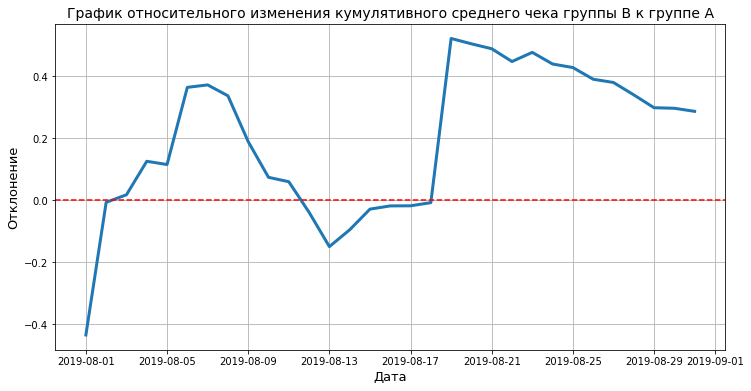

In [19]:
# объединяем кумулятивные данные по среднему чеку
merged_cumulative_revenue  = cumulative_revenue_a.merge(cumulative_revenue_b,
                                                        left_on='date',
                                                        right_on='date',
                                                        how='left',
                                                        suffixes=['_a', '_b'])

# cтроим график
plt.figure(figsize=(12, 6))
plt.plot(merged_cumulative_revenue['date'], 
        (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])
         /(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1, linewidth=3);

# добавляем вспомогательную ось на значении 0
plt.axhline(y=0, color='red', linestyle='--');

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size = 14)
plt.xlabel('Дата', size = 13)
plt.ylabel('Отклонение', size = 13)
plt.grid(True)
plt.show();

На графике относительного изменения кумулятивного среднего чека группы B к группе А выделяются два пика - за 6-7 и 19 августа 2019 г. Для определения характера причин возникших аномалий проверим самые дорогие заказы из группы B, а также рассчитаем разницу в объемах выручки между группами за пиковые даты.

In [20]:
# самые дорогие заказы из группы B
display(orders.query('group == "B"').sort_values(by='revenue', ascending=False).head(10))

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
744,3668308183,888512513,2019-08-27,86620,B
940,2420050534,4003628586,2019-08-08,58550,B
613,4071177889,3931967268,2019-08-07,53904,B
1142,3815014015,2606908679,2019-08-13,52900,B
755,1234615529,2279926127,2019-08-30,45780,B
339,2216192667,834731816,2019-08-25,41450,B
78,773663763,3288820196,2019-08-16,40740,B
1087,324171086,3590655705,2019-08-12,39500,B


In [21]:
# делаем срез выручки по заказам за 6,7 и 19 августа для обеих групп

revenue_6_7_19_august = (
                        orders.query('date in ["2019-08-06","2019-08-07", "2019-08-19"]')
                            .pivot_table(index='date', columns = 'group', values='revenue', aggfunc='sum')
                            .reset_index()
                    )
revenue_6_7_19_august['ratio'] = round((revenue_6_7_19_august['B']/revenue_6_7_19_august['A']), 2)
display(revenue_6_7_19_august)

group,date,A,B,ratio
0,2019-08-06,40919,214842,5.25
1,2019-08-07,123248,219164,1.78
2,2019-08-19,168193,1429920,8.50


Таким образом аномальный всплеск 19 августа действительно обусловлен оформлением очень большого заказа - разница среднего чека между группами более чем 8 раз. В случае пика 6-7 августа, колебания на графике связаны, прежде всего, с низкими значениями выручки группы А при стабильно высокой выручке в группе В.

#### График кумулятивного среднего количества заказов на посетителя по группам

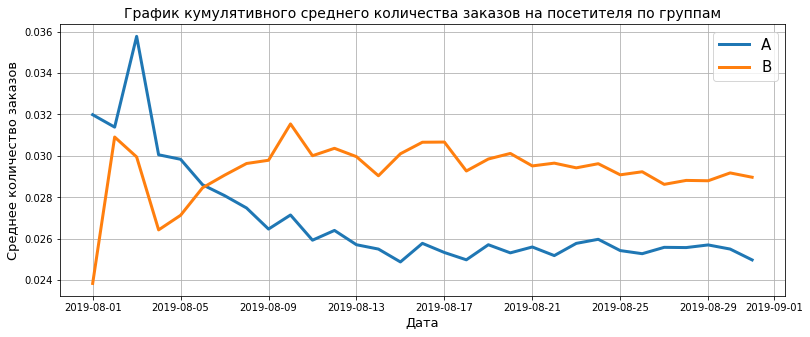

In [22]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# среднее количество заказов на посетителя группы A
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']

# среднее количество заказов на посетителя группы B
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

# строим график
plt.figure(figsize = (13,5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label = 'A', linewidth=3)
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label = 'B', linewidth=3)

plt.title('График кумулятивного среднего количества заказов на посетителя по группам', size = 14)
plt.xlabel('Дата', size = 13)
plt.ylabel("Среднее количество заказов", size = 13)
plt.grid(True)
plt.legend(fontsize=15)
plt.show();

По графику кумулятивного среднего количества заказов на посетителя видим сильные колебания в начале теста по обеим группам.\
Во второй половине теста график выравнивается и становится практически симметричным. К этому моменту результаты группы B стабильно превышают значения группы А.\
К концу теста *кумулятивное среднее группы B установилась на уровне 2.9%, кумулятивное среднее группы А - на уровне 2.5%*.\
В целом абсолютные значения колебаний кумулятивного среднего количества заказов на посетителя для обеих групп варьируются в диапазоне от 2.4% до 3.6%.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

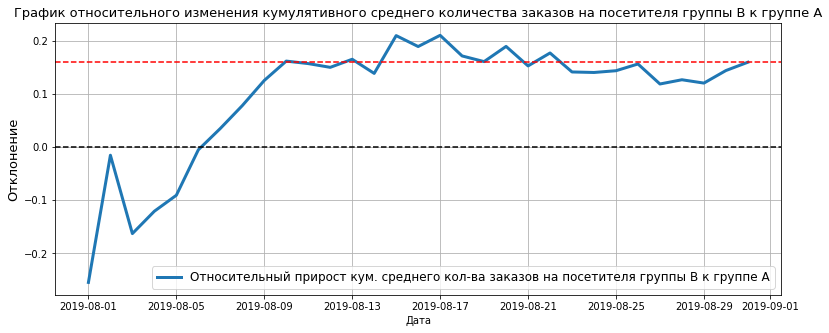

In [23]:
# объединяем данные по кумулятивному среднему количеству заказов на посетителя для обеих групп
merged_cumulative_conversions = cumulative_data_a[['date','conversion']] \
.merge(cumulative_data_b[['date','conversion']], left_on = 'date', right_on = 'date', how = 'left', suffixes = ['_a', '_b'])

# строим график
plt.figure(figsize=(13,5))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b'] / merged_cumulative_conversions['conversion_a'] - 1, \
         label = "Относительный прирост кум. среднего кол-ва заказов на посетителя группы B к группе A", linewidth=3)

# добавляем вспомогательные оси на значении 0 и 0.16
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.16, color = 'red', linestyle = '--')

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A', size = 13)
plt.xlabel('Дата')
plt.legend(fontsize=12)
plt.ylabel('Отклонение', size = 13)
plt.grid(True)
plt.show();

В начале теста группа В проигрывала группе А, но уже на 7-й день вырвалась вперед.\
По графику видим, что кумулятивное среднее количество заказов на посетителя в группе B относительно группы А на 10 августа уже установилось и колебалось вокруг значения 16%.\
Другие значительные скачки и всплески за период тестирования отсутствуют, что говорит о стабильном приросте кумулятивного среднего группы B над группой А.

### Анализ распределения количества заказов по пользователям

В рамках исследования построим точечный график распределения количества заказов по пользователям.

     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


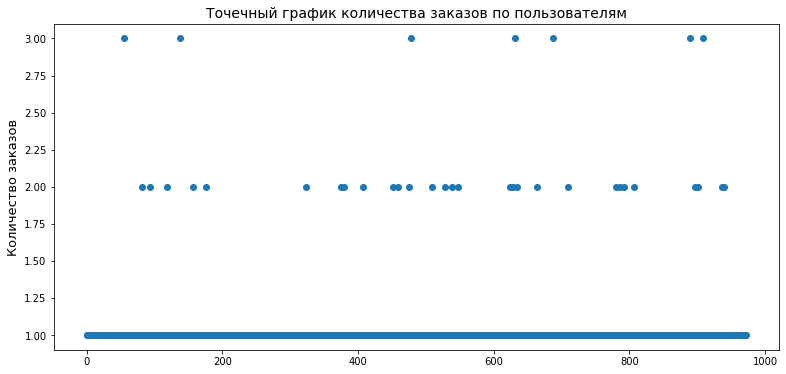

In [24]:
# создаем датафрейм с распределением количества заказов в разрезе пользователей
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в 'orders_by_users'
x_values_orders = pd.Series(range(0, len(orders_by_users)))

# строим точеченый график числа заказов на одного пользователя
plt.figure(figsize=(13,6))
plt.scatter(x_values_orders, orders_by_users['orders']);

plt.title('Точечный график количества заказов по пользователям', size = 14)
plt.ylabel('Количество заказов', size = 13)
plt.show();

Основная часть покупателей сделали только **1 заказ**. Однако встречается некоторая доля тех, кто оформил по 2 или 3 заказа. Чтобы конкретизировать их количество и проследить влияние на результаты тестирования, посчитаем 95-й и 99-й перцентили количества заказов на пользователя, после чего установим границу для усечения аномальных значений.

In [25]:
# расчет 95 и 99 перцентилей количества заказов на пользователя
display(np.percentile(orders_by_users['orders'], [95, 99]))

array([1., 2.])

Не более 5% пользователей оформляли больше 1 заказа.\
Не более 1% пользователей заказывали больше 2 раз.\
Таким образом установим 1 заказ как верхнюю границу числа заказов, выше которой - выбросы.

### Анализ распределения стоимостей заказов

В рамках исследования построим точечный график распределения стоимостей заказов.

      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  1294500     B
1196      3936777065  2108080724 2019-08-15   202740     B
1136       666610489  1307669133 2019-08-13    92550     A
744       3668308183   888512513 2019-08-27    86620     B
743       3603576309  4133034833 2019-08-09    67990     A
1103      1348774318  1164614297 2019-08-12    66350     A
1099       316924019   148427295 2019-08-12    65710     A
949       1347999392   887908475 2019-08-21    60450     A
940       2420050534  4003628586 2019-08-08    58550     B
131       3163614039  2254586615 2019-08-22    53904     A


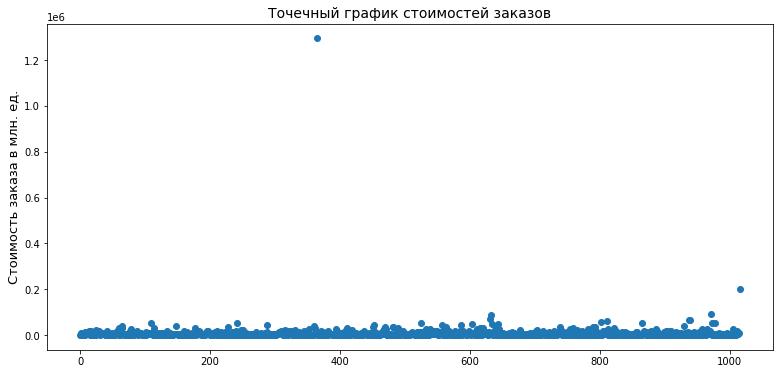

In [26]:
# проверим самые крупные заказы по выручке
print(orders.sort_values(by='revenue', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в 'orders_by_users'
x_values_revenue = pd.Series(range(0, len(orders['revenue'])))

# строим точеченый график числа заказов на одного пользователя
plt.figure(figsize=(13,6))
plt.scatter(x_values_revenue, orders['revenue'])
plt.title('Точечный график стоимостей заказов', size = 14)
plt.ylabel('Стоимость заказа в млн. ед.', size = 13)
plt.show();

По графику и таблице распределения стоимостей заказов видим аномально дорогой заказ на сумму 1.3 млн.ед, совершенный 19 августа 2019 года.\
На графике так же заметен крупный заказ на 202.7 тыс. ед.\
Все остальные наблюдения варьируются в диапазоне до 92 тыс. ед.\
Для подтверждения статуса аномалии в выборке рассчитаем 95 и 99 перцентили стоимостей заказов, которые могут влиять на результаты исследований.

In [27]:
# расчет 95 и 99 перцентилей стоимостей заказов
display(np.percentile(orders['revenue'], [95, 99]))

array([26785., 53904.])

Не более 5% заказов дороже 26.7 тыс. ед.\
Не более 1% заказов чек выше 53.9 тыс.ед.\
Таким образом границей для определения аномально дорогих заказов обозначим 99-й перцентиль - 53.9 тыс. ед.

### Анализ статистической значимости

По итогам анализа кумулятивных результатов A/B теста и определения границы аномальных значений в исследуемой выборке, рассчитаем статистическую значимость различий в среднем количестве заказов на пользователя и среднем чеке между группами тестирования.\
Для этого сформулируем нулевую и альтернативную гипотезы для каждого параметра.

В связи с тем, что в исследуемых данных присутствуют выбросы, для проверки гипотез будем использовать *непараметрический тест Уилкоксона-Манна-Уитни*, который хорошо решает проблему, когда величины распределены ненормально.

*Уровень статистической значимости: α = 0.05.*

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Обозначим нулевую и альтернативную гипотезы:

* **H0**: статистически значимых различий в среднем количестве заказов на посетителя между группами А и В по «сырым» данным нет.
* **H1**: статистически значимые различия в среднем количестве заказов на посетителя между группами А и В по «сырым» данным есть.

Перед тем, как перейти к тесту Манна-Уитни, подготовим данные о среднем количестве заказов на посетителя для каждой группы.

In [28]:
# создаем датафреймы с пользователями, которые совершили хотя бы один заказ, по группам
# укажем количество заказов

#группа А
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

#группа В
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

In [29]:
# готовим выборки к проверке критерием Манна-Уитни
# создаем выборки по группам с количеством заказов определенного пользователя
# в т.ч. пользователи, у которых 0 заказов

# выборка для группы А
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0
                    )

# выборка для группы В
sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0
                    )

In [30]:
# уровень статистической значимости
alpha = 0.05

# считаем статистическую значимость различий в количестве заказов на посетителя по сырым данным критерием Манна-Уитни
results_1 = st.mannwhitneyu(sample_a, sample_b)

print('p-значение: {0:.3f}'.format(results_1.pvalue))

if results_1.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')

# считаем относительный прирост среднего количества заказов группы В
print('Относительный прирост среднего количества заказов на посетителя группы В к группе А: {0:.2f}'.format(sample_b.mean() / sample_a.mean() - 1))

p-значение: 0.011
Отвергаем нулевую гипотезу: разница статистически значима.
Относительный прирост среднего количества заказов на посетителя группы В к группе А: 0.16


По "сырым" данным различия в среднем количестве заказов на посетителя между группами есть: p-значение меньше уровня статистической значимости. Таким образом, *нулевую гипотезу отвергаем в пользу альтернативной*.\
*Относительный выигрыш группы В по среднему количеству заказов на посетителя составляет 16%*. Это говорит о том, что в группе B количество заказов на посетителя в среднем на 16% выше группы А.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Обозначим нулевую и альтернативную гипотезы:

* **H0**: статистически значимых различий в среднем чеке заказа между группами А и В по «сырым» данным нет.
* **H1**: статистически значимые различия в среднем чеке заказа между группами А и В по «сырым» данным есть.

In [31]:
# считаем статистическую значимость различий в среднем чеке заказа  по сырым данным критерием Манна-Уитни
results_2 = st.mannwhitneyu(orders[orders['group'] =='A']['revenue'], orders[orders['group'] =='B']['revenue'])

print('p-значение: {0:.3f}'.format(results_2.pvalue))

if results_2.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')

# считаем различия в среднем чеке для группы В относительно группы А
print('Относительный прирост среднего чека группы В к группе А: {0:.3f}'\
      .format(orders[orders['group'] =='B']['revenue'].mean()
     / orders[orders['group'] =='A']['revenue'].mean() - 1))

p-значение: 0.829
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.
Относительный прирост среднего чека группы В к группе А: 0.287


По "сырым" данным различия в среднем чеке между группами отсутствуют: p-значение больше уровня статистической значимости. Таким образом, *нулевую гипотезу не отвергаем*.\
*Относительный выигрыш группы B по среднему чеку составляет 28.7%*. Это говорит о том, что в группе B в среднем на 28.7% заказы дороже по сравнению с группой A.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Для получения наиболее релевантных результатов теста Манна-Уитни уберем из выборки аномальных пользователей, попадающих под следующие критерии:
- те, кто совершил 2 и более заказов (1% пользователей с наибольшим числом заказов);
- те, кто совершил заказ на сумму от 54 тысяч ед. (1% пользователей с самыми дорогими заказами).

In [32]:
# определяем точные значения для среза аномалий
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)

# пользователи, у которых более 2 заказов
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)

# пользователи, у которых заказы дороже 54 тысяч
users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']

# объединяем аномальных пользователей в единый датафрейм
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head())
print()
print('Количество аномальных пользователей всего:', abnormal_users.shape[0])
print('Доля аномальных пользователей в общем количестве исследуемых пользователей: {0:.2f}%'.format((abnormal_users.shape[0]/orders['visitor_id'].nunique())*100))

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitor_id, dtype: int64

Количество аномальных пользователей всего: 16
Доля аномальных пользователей в общем количестве исследуемых пользователей: 1.64%


Обозначим нулевую и альтернативную гипотезы:

* **H0**: статистически значимых различий в среднем количестве заказов на посетителя между группами А и В по «очищенным» данным нет.
* **H1**: статистически значимые различия в среднем количестве заказов на посетителя между группами А и В по «очищенным» данным есть.

Перед тем, как перейти к тесту Манна-Уитни, подготовим "очищенные" данные о среднем количестве заказов на посетителя для каждой группы.

In [33]:
# готовим выборки количества заказов по пользователям в разрезе групп

# группа А
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# группа В
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [34]:
# считаем статистическую значимость различий в количестве заказов по "очищенным" данным критерием Манна-Уитни
results_3 = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)

print('p-значение: {0:.3f}'.format(results_3.pvalue))

if results_3.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')

# считаем относительный прирост среднего количества заказов группы В
print('Относительный прирост среднего количества заказов на посетителя группы В к группе А: {0:.2f}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

p-значение: 0.007
Отвергаем нулевую гипотезу: разница статистически значима.
Относительный прирост среднего количества заказов на посетителя группы В к группе А: 0.19


Результат по "очищенным" данным немного отличается от первого теста, но не меняет общий исход эксперимента.\
P-значение осталось меньше уровня статистической значимости, поэтому *нулевая гипотеза отвергается в пользу альтернативной*.
*Относительный прирост среднего количества заказов на посетителя группы В составил 19%.* Таким образом в группе B количество заказов на посетителя в среднем на 19% выше, чем в группе A.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Обозначим нулевую и альтернативную гипотезы:

* **H0**: статистически значимых различий в среднем чеке заказа между группами А и В по «очищенным» данным нет.
* **H1**: статистически значимые различия в среднем чеке заказа между группами А и В по «очищенным» данным есть.

In [35]:
# считаем статистическую значимость различий в среднем чеке заказа по "очищенным" данным критерием Манна-Уитни
results_4 = st.mannwhitneyu(orders[(orders['group']=='A') &\
                                   np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'],\
                            orders[(orders['group']=='B')\
                                   & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'])

print('p-значение: {0:.3f}'.format(results_4.pvalue))

if results_4.pvalue < alpha:
        print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')

# считаем различия в среднем чеке для группы В относительно группы А
print('Относительные различия среднего чека группы В к группе А: {0:.3f}'\
      .format(orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'].mean()
     / orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'].mean() - 1))

p-значение: 0.788
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.
Относительные различия среднего чека группы В к группе А: -0.032


Результаты теста по "очищенным" данным для среднего чека оказались примерно на том же уровне, что и при оценке "сырых" данных. P-значение сильно больше уровня статистической значимости, поэтому *нулевую гипотезу не отвергаем*.\
При этом средний чек сегмента В упал настолько, что оказался в относительном проигрыше к сегменту А: разница составила 3.2%.\
Таким образом чистка очень дорогих заказов, характерных для группы В, привела к *минимизации разрыва по среднему чеку* между группами тестирования.

**Выводы о результатах A/B теста**
1. Есть статистически значимое различие по *среднему количеству заказов на посетителя* между группами как по «сырым», так и по данным после фильтрации аномалий. Количество заказов на посетителя группы B в среднем на 19% выше по сравнению с группой A.
2. Нет статистически значимого различия по *среднему чеку* между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом средний чек в группе B после устранения выбросов показал околонулевой относительный проигрыш, уступив группе А 3.2%.
3. График *относительного изменения кумулятивного среднего количества заказов на посетителя* группы B к группе A показывает, что результаты группы В стабильно лучше группы А.

Таким образом по очищенным данным количество заказов на посетителя группы В в среднем выше, чем у группы А, в то время как средний чек между группами не отличается.\
Исходя из всех вышеобозначенных фактов, **рекомендуется остановить тест, зафиксировав победу группы B**. Продолжение теста при текущем уровне статистической значимости не поменяет картину в целом.

## Общий вывод

В ходе проекта былы проведена приоритизация ряда жизнеспособных для бизнеса гипотез, а также анализ результатов A/B теста с целью увеличения выручки интернет-магазина. Основой реализации A/B тестирования явились записи о заказах и посещениях пользователей интернет-магазина за период с 1 по 31 августа 2019 года.

Исследование выполнялось по следующим этапам:
1. **Загрузка и первичный анализ данных**:

* Датафрейм "Гипотезы" содержит 9 гипотез, предложенных отделом маркетинга, которые актуальны и могут поспособствовать увеличению прибыли компании;
* Датафрейм "Посещения" включает сведения о количестве посещений пользователей интернет-магазина по группам теста в определенные даты;
* Датафрейм "Заказы" содержит информацию о заказах пользователей по группам теста в определенные даты.


2. **Предобработка данных**:
* скорректированы наименования столбцов;
* пропуски и явные дубликаты не выявлены;
* исключены сведения о пользователях, попавших одновременно в обе группы A/B теста.

3. **Приоритизация гипотез**

* Наиболее приоритетные гипотезы по фреймворку ICE (*без учета охвата пользователей*):
     * `запустить акцию, дающую скидку на товар в день рождения (гипотеза № 8);`
     * `добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (гипотеза № 0);`
     * `добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (гипотеза № 7).`
     
     
* Наиболее приоритетные гипотезы по фреймворку RICE (*с учетом охвата пользователей*):
     * `добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (гипотеза № 7);`
     * `добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (гипотеза № 2);`
     * `добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (гипотеза № 0).`
     
Учитывая важность параметра охвата пользователей в стратегии развития интернет-магазина, наиболее приоритетными гипотезами являются гипотезы №7, №2 и №0. Именно на них необходимо обратить внимание в случае планирования A/B-теста. 

4. **Анализ результатов A/B теста**\
A/B тест рекомендуется *остановить и признать успешным в пользу группы B*, зафиксировав следующие уточнения:

    * есть статистически значимое различие по *среднему количеству заказов на посетителя* между группами как по «сырым», так и по данным после фильтрации аномалий. Количество заказов на посетителя группы B в среднем на 19% выше по сравнению с группой A;
    * нет статистически значимого различия по *среднему чеку* между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом средний чек в группе B после устранения выбросов показал околонулевой относительный проигрыш, уступив группе А 3.2%;
    * график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A показывает, что результаты группы В стабильно лучше группы А.

Таким образом по очищенным данным количество заказов на посетителя группы В в среднем выше, чем у группы А, в то время как средний чек между группами не отличается.